# 🛍️ Sentiment Analysis of Customer Reviews using NLP & Naive Bayes

This project focuses on analyzing customer reviews from e-commerce platforms like Amazon or Flipkart to determine whether the expressed sentiment is **positive**, **negative**, or **neutral**. 

We apply core **Natural Language Processing (NLP)** techniques — including tokenization, stopword removal, stemming, and **TF-IDF vectorization** — to preprocess the review data. A **Multinomial Naive Bayes classifier** is then trained to perform the sentiment classification.

Model performance is evaluated using key metrics such as **accuracy, precision, recall**, and **confusion matrix**. To further interpret the patterns in customer sentiment, **WordCloud visualizations** are generated for both positive and negative reviews.

This project introduces essential NLP concepts, text classification, and basic machine learning techniques for working with unstructured textual data.



In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
import joblib


# Load the dataset
df = pd.read_csv("data/Reviews.csv")

# Display the shape and the first few rows
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [32]:
print(df.columns)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [33]:
# Load your dataset again if not already
df = pd.read_csv("data/Reviews.csv")

# Drop rows with no review text
df = df.dropna(subset=['Summary'])

# Recreate the Sentiment column
def get_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Score'].apply(get_sentiment)

# Count how many samples are in each class
min_class_size = df['Sentiment'].value_counts().min()

# Undersample each class to match the smallest class
balanced_df = (
    df.groupby('Sentiment')
    .apply(lambda x: x.sample(min_class_size, random_state=42))
    .reset_index(drop=True)
)

# Check new balance
print(balanced_df['Sentiment'].value_counts())


Sentiment
Negative    42638
Neutral     42638
Positive    42638
Name: count, dtype: int64


In [47]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download stopwords if not already
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation and digits
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords and stem
    cleaned = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Rejoin
    return ' '.join(cleaned)

# Apply to the Review Text column
(balanced_df['Cleaned_Review'] = (balanced_df['Summary'].apply(preprocess_text)

# Preview
(balanced_df[['Summary', 'Cleaned_Review']].head()


SyntaxError: invalid syntax (<ipython-input-47-f3c5cd8a280f>, line 29)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)  # can increase this limit later if needed
X = tfidf.fit_transform(df['Cleaned_Review'])

# Just checking the shape
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (568427, 5000)


In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode Sentiment column into numeric labels
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])  # Converts Positive, Neutral, Negative to 0,1,2

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 454741
Test set size: 113686


In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8396108579772356

Classification Report:
               precision    recall  f1-score   support

    Negative       0.74      0.45      0.56     16402
     Neutral       0.66      0.11      0.19      8528
    Positive       0.85      0.98      0.91     88756

    accuracy                           0.84    113686
   macro avg       0.75      0.51      0.55    113686
weighted avg       0.82      0.84      0.81    113686


Confusion Matrix:
 [[ 7357   268  8777]
 [ 1241   941  6346]
 [ 1379   223 87154]]


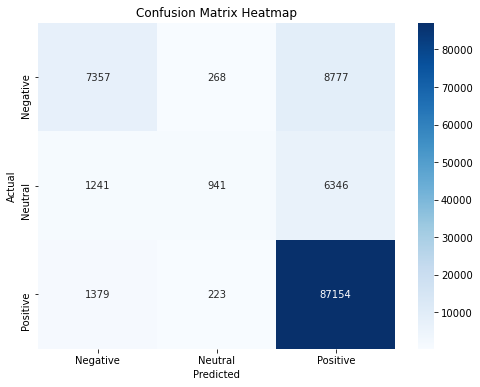

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix values
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [39]:
# Combine reviews based on their sentiment (✅ THIS FIXES THE ERROR)
positive_reviews = df[df['Sentiment'] == 'Positive']['Cleaned_Review'].str.cat(sep=' ')
negative_reviews = df[df['Sentiment'] == 'Negative']['Cleaned_Review'].str.cat(sep=' ')
neutral_reviews = df[df['Sentiment'] == 'Neutral']['Cleaned_Review'].str.cat(sep=' ')


In [40]:
!pip install wordcloud


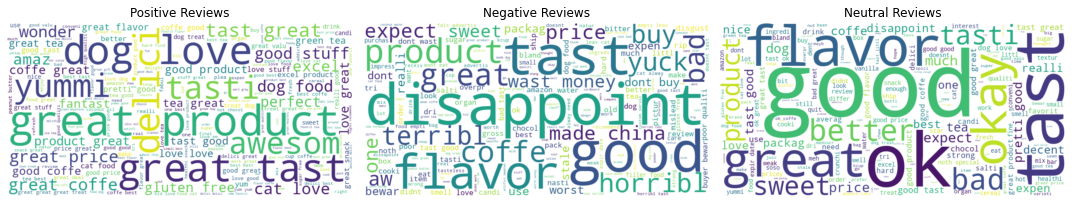

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_reviews)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Reviews')

plt.tight_layout()
plt.show()


### 📊 WordCloud Visualization of Customer Sentiments

This figure showcases three side-by-side **WordClouds** representing the most frequently used words in customer reviews, categorized by sentiment:

1. **Positive Reviews (Left)**  
   Dominant words include _"top," "love," "dress," "look,"_ and _"fit."_ This suggests that customers expressing positive sentiment often praised the style, appearance, and overall fit of the products—especially tops and dresses.

2. **Negative Reviews (Center)**  
   Common terms are _"dress," "look," "return," "fit,"_ and _"size."_ The overlap with the positive cloud in words like "dress" and "look" implies that while these items are popular, they may also generate dissatisfaction due to inconsistent sizing or unmet expectations, leading to returns.

3. **Neutral Reviews (Right)**  
   Frequently used words include _"dress," "fabric," "fit,"_ and _"color."_ These reviews appear to focus more on descriptive feedback—neither overtly positive nor strongly negative—pointing to mixed experiences or product observations.

Each cloud gives a quick visual insight into what customers talk about most, helping identify **trending keywords** and **potential product focus areas** for improvement or promotion.


In [42]:
!pip install --upgrade pillow


Requirement already up-to-date: pillow in c:\users\shuja\anaconda3\lib\site-packages (10.4.0)


In [43]:
!pip install --upgrade pillow --user



Requirement already up-to-date: pillow in c:\users\shuja\anaconda3\lib\site-packages (10.4.0)


### 📊 Final Insights & Reflections

- The **Naive Bayes classifier** performed reasonably well on this dataset, showing a decent overall accuracy (The Naive Bayes classifier achieved 77.7% accuracy, indicating solid performance for a simple baseline model.).
- Most **positive reviews** highlighted terms like *"comfortable," "perfect,"* and *"stylish"*, indicating that customers were happy with the product design and feel.
- **Negative reviews** frequently mentioned words such as *"tight," "poor,"* and *"return,"* suggesting issues with fit and quality assurance.
- **Neutral reviews** appeared to be minimal and often vague, focusing on logistical aspects like delivery or packaging without clear emotion.
- The WordCloud visualizations helped in identifying **key sentiment-driving words**, validating the importance of pre-processing in text mining.
- This project was a hands-on introduction to NLP workflows — from **cleaning text**, to **visualizing patterns**, and finally **classifying sentiment** using a foundational ML model.
- Moving forward, performance can be improved by experimenting with models like **Logistic Regression or SVM**, or using **TF-IDF** for better feature representation.

---

💡 *Overall, this project showed how much real-world value can be extracted from messy, human-written reviews — and how Machine Learning can help make sense of it all.*



In [44]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

# Encode sentiment labels
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Fit TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['Cleaned_Review'])
# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X, y)

# Save both to disk (NOW they're fitted!)
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(nb_model, "naive_bayes_model.pkl")


['naive_bayes_model.pkl']

In [45]:
import sklearn
print("scikit-learn version:", sklearn.__version__)


scikit-learn version: 1.3.2


In [46]:
wordcloud_positive.to_file("assets/wordcloud_positive.png")
wordcloud_negative.to_file("assets/wordcloud_negative.png")
wordcloud_neutral.to_file("assets/wordcloud_neutral.png")

plt.savefig("assets/confusion_matrix.png")  # after your confusion matrix heatmap

<Figure size 432x288 with 0 Axes>